# Setup

First, set up the required Python modules and perform some general configuration.

Text classification using CNNs and RNNs

We have prepared two notebooks for training a sentiment classifier using the IMDB movie review dataset. The first notebook uses a CNN text classification model while the second notebook uses a simple RNN model.

CNN notebook

RNN notebook

Your task is to carefully study the notebooks, and write a step-by-step summary of key steps to train and evaluate such a model. Keep in mind that many of these steps will be applicable throughout the course, even if the specific model differs. Therefore, it is essential to grasp the key concepts.

The summary can be composed as e.g. a bulleted list with a brief explanation of each step (including its purpose, input, output, etc.) or as comments within the code in the original notebook. The primary goal of this exercise is to facilitate learning, so the choice of how you write the summary is entirely up to you. Focus on highlighting the key concepts.

Upload as a notebook or a text file.



Hyperparameter optimization

Both the CNN and RNN notebooks showed improvements over the 50% random baseline, however, this does not represent a particularly high level of performance for this dataset. Can you improve on the performance by adjusting the hyperparameters?

Report which hyperparameters you modified and how these modifications affected the results. What is the highest accuracy you were able to achieve?

You can experiment with these hyperparameters (or any other parameters you find interesting): max_length, embedding_dim, filter_size (CNN), num_filters (CNN), hidden_size (RNN), nonlinearity (RNN), learning_rate, per_device_train_batch_size, max_steps


Install the required Python packages using [pip](https://en.wikipedia.org/wiki/Pip):

* [`transformers`](https://huggingface.co/docs/transformers/index) is a popular deep learning package
* [`datasets`](https://huggingface.co/docs/datasets/) provides support for loading, creating, and manipulating datasets
* [`evaluate`](https://huggingface.co/docs/evaluate/index) is a library for easily evaluating machine learning models and datasets
* [`accelerate`](https://pypi.org/project/accelerate/) is a wrapper we need to install in order to train torch models using a transformers trainer

Both `transformers` and `datasets` are used extensively on this course.

In [ ]:
!pip3 install -q transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00


(Above, the `!` at the start of the line tells the notebook to run the line as an operating system command rather than Python code, and the `-q` argument to `pip` runs the command in "quiet" mode, with less output.)

We'll also use the [`pprint`](https://docs.python.org/3/library/pprint.html) ("pretty-print") module to format output more readably below. The only difference to just using `print` is that some data structures will be easier to read and interpret.

In [ ]:
from pprint import PrettyPrinter

pprint = PrettyPrinter(compact=True).pprint

Finally, we will reduce logging output. The `transformers` library by default produces fairly verbose logging. Commenting out the following code will enable low-priority output (`INFO` logging level and below).

In [ ]:
import logging

logging.disable(logging.INFO)

---

# Download and prepare data

We will use the `datasets` library function [`load_dataset`](https://huggingface.co/docs/datasets/master/en/package_reference/loading_methods#datasets.load_dataset) to load a dataset for our experiments.

In [ ]:
import datasets


dataset = datasets.load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Let's see what the dataset contains:

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


and print out an example:

In [ ]:
pprint(dataset['train'][0])

{'label': 0,
 'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the '
         'controversy that surrounded it when it was first released in 1967. I '
         'also heard that at first it was seized by U.S. customs if it ever '
         'tried to enter this country, therefore being a fan of films '
         'considered "controversial" I really had to see this for myself.<br '
         '/><br />The plot is centered around a young Swedish drama student '
         'named Lena who wants to learn everything she can about life. In '
         'particular she wants to focus her attentions to making some sort of '
         'documentary on what the average Swede thought about certain '
         'political issues such as the Vietnam War and race issues in the '
         'United States. In between asking politicians and ordinary denizens '
         'of Stockholm about their opinions on politics, she has sex with her '
         'drama teacher, classmates, and married men.<br

---

# Tokenize and vectorize data

To tokenize and vectorize the texts of our dataset, we will use previously created tokenizers through the simple [`AutoTokenizer`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) class.

The [`AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer.from_pretrained) function can load the tokenizer associated with any of the large number of models found in the [Hugging Face models repository](https://huggingface.co/models). Here, our texts are in English, and we'll load the tokenizer for the [`bert-base-cased`](https://huggingface.co/bert-base-cased) model.

(**Note**: we're not actually using the BERT model here, just its tokenizer.)

In [ ]:
import transformers

model_name = "bert-base-cased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

The tokenizers in the transformers library take a text string as argument and both split the text into tokens (tokenization) and map those tokens into integer identifiers (vectorization).

The values returned by the tokenizer depend on the model that the tokenizer was created for, but normally include at least `input_ids`, which are the result of tokenization and vectorization:

In [ ]:
pprint(tokenizer.tokenize("This is an example sentence."))
pprint(tokenizer("This is an example sentence."))

['This', 'is', 'an', 'example', 'sentence', '.']
{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101, 1188, 1110, 1126, 1859, 5650, 119, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0]}


We can ignore the values other than `input_ids` returned by the tokenizer (`token_type_ids` and `attention_mask`) for now. We will come back to these later in the course.

We can now tokenize and vectorize our whole dataset with the tokenizer by defining a simple tokenization function and calling the [`Dataset.map`](https://huggingface.co/docs/datasets/v2.14.4/en/package_reference/main_classes#datasets.Dataset.map) function.

If the function returns a column that already exists, then it overwrites the value, otherwise it adds a new column. Here, the call adds the values returned by the tokenizer() call (input_ids etc.) to each example while also keeping the original text and label values.

Note that here we're providing a `max_length` argument and `truncation=True` in the tokenizer call. This limits the maximum length of outputs to the given length (see the [tokenizers documentation](https://huggingface.co/docs/transformers/preprocessing#everything-you-always-wanted-to-know-about-padding-and-truncation) for details). This makes training faster, potentially at some cost in performance.

In [ ]:
# Define a simple function that applies the tokenizer
def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=208,
        truncation=True,
    )

# Apply the tokenizer to the whole dataset using .map()
dataset = dataset.map(tokenize)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
pprint(dataset["train"][0])

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101, 146, 12765, 146, 6586, 140, 19556, 19368, 13329, 118, 162,
               21678, 2162, 17056, 1121, 1139, 1888, 2984, 1272, 1104, 1155,

---

# Build model

A PyTorch model class should have an `__init__()` function which instantiates the layers and a `forward()` function which implements the actual computation. For more information on these, please see the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html).

We're here building a simple version of the CNN text classification model proposed by [Kim (2014) _Convolutional Neural Networks for Sentence Classification_](https://arxiv.org/pdf/1408.5882.pdf).

The architecture of our simplified version is illustrated in the following figure:

![foo](https://raw.githubusercontent.com/TurkuNLP/Deep_Learning_in_LangTech_course/master/figs/simple-cnn.png)

The model has the following architecture:

* First, the token IDs are mapped to embeddings of a user-specified size (`config.embedding_dim`) in a [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer. Note that here the embeddings are initialized randomly and learned along with other model weights. In real-world applications, the embeddings would typically be initialized with previously learned weights.
* Second, a user-specified number of filters (`config.num_filters`) is applied to the matrix formed by the sequence of token embedding in a convolution layer ([torch.nn.Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)). As explained on the previous lecture, the width of the filters matches the width of the embeddings, and the convolution is one-dimensional. The filter weights are initialized randomly and learned along with other model weights, as is common in CNN models.
* Third, the outputs of the convolution are passed through a non-linear activation function, here the simple ReLU ([torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)) which thresholds each value at 0 ($\textrm{max}(0,x)$, i.e. any value < 0 is set to 0).  
* Next, the outputs are max-pooled globally using [torch.nn.AdaptiveMaxPool1d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool1d.html), taking only the largest value output by each of the filters (after the activation function). This introduces _translation invariance_: the pooled output contains information on how well each filter "matched" the input, but not _where_ that "match" was found.
* Finally, there is a fully connected layer ([torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) that maps the pooled values to the two possible output values.

We can interpret this model as attempting to learn _n_-gram feature detectors (the filters, where _n_ is the filter size) for statements that express either positive or negative opinions in a way that is independent of _where_ in the input the _n_-gram feature appears.

In the `forward` function we mostly just pass the input through the various layers, with the following additional steps:

* After the embedding layer, we call [permute](https://pytorch.org/docs/stable/generated/torch.permute.html) to reorder the last two dimensions from (embedding-index, word-sequence-position) to (word-sequence-position, embedding-index) as [torch.nn.Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) expects this order.
* After the pooling layer, we call [flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html) to drop a dimension of size one left by the pooling, producing a vector for each example in the batch. (Note `start_dim=1` here to avoid flattening the whole batch of examples.)

(These steps can be considered technical details and understanding them in detail is not required to understand the model.)

In [ ]:
import torch


# This gives a new name to the config class, just for convenience
BasicConfig = transformers.PretrainedConfig


# This is the model
class SimpleCNN(transformers.PreTrainedModel):

    config_class = BasicConfig

    # In the initialization method, one instantiates the layers
    # these will be the parameters of the model
    def __init__(self, config):
        super().__init__(config)
        # Embedding layer: vocab size x embedding dim
        self.embeddings = torch.nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.embedding_dim
        )
        # Convolution layer: TODO
        self.convolution = torch.nn.Conv1d(
            config.embedding_dim,
            config.num_filters,
            config.filter_size,
            padding=1
        )
        # Activation function following convolution
        self.activation = torch.nn.ReLU()
        # Pooling layer: global max pooling, regardless of input length
        self.pooling_layer = torch.nn.AdaptiveMaxPool1d(
            output_size=1
        )
        # Output layer: num filters to output size
        self.output_layer = torch.nn.Linear(
            in_features=config.num_filters,
            out_features=config.num_labels
        )
        # Loss function: standard loss for classification
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, input_ids, labels=None, attention_mask=None):
        #shape of input: [batch_size, maxlen]
        x = self.embeddings(input_ids)
        #shape of x: [batch_size, maxlen, embedding_dim]
        x = x.permute((0,2,1))
        #shape of x: [batch_size, embedding_dim, maxlen]
        x = self.convolution(x)
        #shape of x: [batch_size, filters, maxlen]
        x = self.activation(x)
        #shape of x: [batch_size, filters, maxlen]
        x = self.pooling_layer(x)
        #shape of x: [batch_size, filters, 1]
        x = x.flatten(start_dim=1)
        #shape of x: [batch_size, filters]
        output = self.output_layer(x)

        # Return value computed as in the MLP:
        if labels is not None:
            # We have labels, so we can calculate the loss
            return (self.loss(output,labels), output)
        else:
            # No labels, so just return the output
            return (output,)

# Configure model

We'll first configure and instantiate the model. Here `vocab_size` should always be the vocabulary size of the tokenizer and `num_labels` the number of unique labels in the data (as here), but the other three are hyperparameters that you can choose:

* `embedding_dim`: the size of the word (i.e. token) embeddings
* `filter_size`: the size ("length") of the convolution filters (2 for bigrams, 3 for 3-grams, etc.)
* `num_filters`: the number of different convolution filters

In [ ]:
config = BasicConfig(
    vocab_size = tokenizer.vocab_size,
    num_labels = len(set(dataset['train']['label'])),
    embedding_dim = 96,
    filter_size = 3,
    num_filters = 16,
)

model = SimpleCNN(config)

# Train model

We will use the Hugging Face [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class for training

* Loads of arguments that control the training
* Configurable metrics to evaluate performance
* Data collator builds the batches
* Early stopping callback stops when eval loss no longer improves


First, let's create a TrainingArguments object to specify hyperparameters and various other settings for training.

Printing this simple dataclass object will show not only the values we set, but also the defaults for all other arguments. Many are not relevant to us here, but the following are hyperparameters that you may wish to adjust:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per batch
* `max_steps`: the maximum number of steps to train for

In [ ]:
# Set training arguments
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=500,
    logging_steps=500,
    learning_rate=0.01,
    per_device_train_batch_size=16,
    max_steps=3000,
)

Next, let's create a metric for evaluating performance during and after training. We can use the convenience function `evaluate.load` to load one of many pre-made metrics and wrap this for use by the trainer.

As the task is simple multi-class classification, we'll use the basic `accuracy` metric, defined as the proportion of correctly predicted labels out of all labels.

We'll yet need to create a [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main_classes/data_collator#transformers.DataCollatorWithPadding) to pad inputs to the same length (as required for batching) and an [EarlyStoppingCallback](https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback) to stop training when performance fails to improve for the given number of evaluations.

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)

data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

Finally, we'll create a simple custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [ ]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

We then pass the model, trainer arguments, training and evaluation data, metric, the collator, and the callback to a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) and call `.train()` to train the model.

In [ ]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
500,0.687500,0.534200,0.726920
1000,0.547800,0.480216,0.768000
1500,0.503300,0.444292,0.792920
2000,0.373800,0.446745,0.808840
2500,0.335700,0.443098,0.813600
3000,0.322100,0.431776,0.816320


TrainOutput(global_step=3000, training_loss=0.46170703125, metrics={'train_runtime': 99.8941, 'train_samples_per_second': 480.509, 'train_steps_per_second': 30.032, 'total_flos': 278986326528.0, 'train_loss': 0.46170703125, 'epoch': 1.92})

---

# Results

Evaluate and print out results:

In [ ]:
eval_results = trainer.evaluate(dataset["test"])

pprint(eval_results)

print('Accuracy:', eval_results['eval_accuracy'])

{'epoch': 1.92,
 'eval_accuracy': 0.81632,
 'eval_loss': 0.431776225566864,
 'eval_runtime': 9.7696,
 'eval_samples_per_second': 2558.956,
 'eval_steps_per_second': 319.87}
Accuracy: 0.81632


Let's also have a look at training and evaluation loss and evaluation accuracy progression. (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

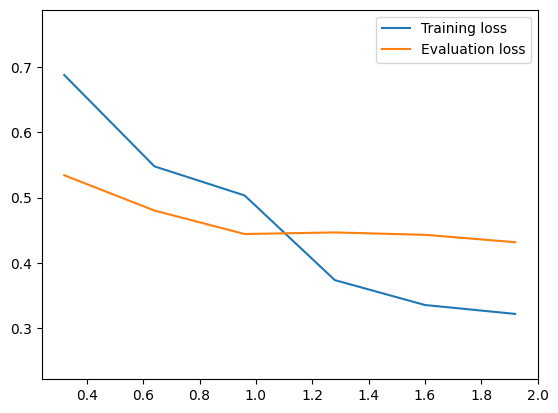

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

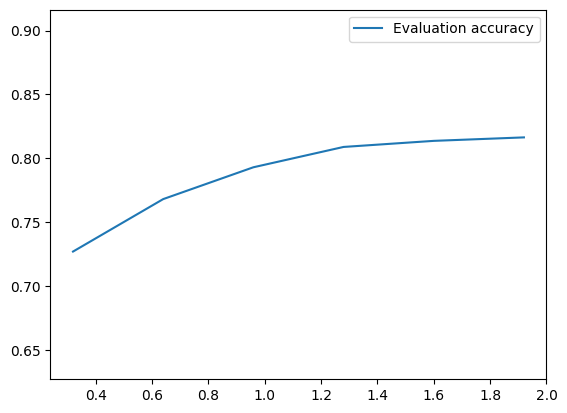

In [ ]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])

Both losses are decreasing and accuracy has improved over the 50% baseline, so the model is definitely learning. However, this is not a particularly high level of performance for this data. Can you improve on the performance e.g. by modifying the model structure or the training hyperparameters?